In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9973, -2.8622, -2.9027, -2.8799, -2.8835, -2.8721, -2.9165, -2.9049,
         -2.8048, -2.9403, -2.9441, -2.8543, -2.8733, -2.8680, -2.8747, -2.8612,
         -2.9144, -2.8875]], grad_fn=<LogSoftmaxBackward>)


In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Kalb
category = Russian / line = Harlampovich
category = Chinese / line = Shaw
category = French / line = Borde
category = Greek / line = Vamvakidis
category = Vietnamese / line = an
category = Chinese / line = Hor
category = English / line = Newby
category = Arabic / line = Qureshi
category = Japanese / line = Ihara


In [9]:
criterion = nn.NLLLoss()

In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.6208 Mclean / Irish ✗ (Scottish)
10000 10% (0m 9s) 1.6865 Pavesi / Italian ✓
15000 15% (0m 15s) 3.9500 Close / Irish ✗ (Greek)
20000 20% (0m 21s) 2.2951 Durylin / Irish ✗ (Russian)
25000 25% (0m 27s) 3.6757 Haanrade / French ✗ (Dutch)
30000 30% (0m 34s) 1.8388 Von essen / Dutch ✗ (German)
35000 35% (0m 40s) 0.0794 Wojewodzki / Polish ✓
40000 40% (0m 46s) 1.6419 Vincent / Dutch ✗ (French)
45000 45% (0m 52s) 2.7485 Christie / French ✗ (Scottish)
50000 50% (0m 58s) 2.2895 Rosales / Greek ✗ (Spanish)
55000 55% (1m 4s) 1.1837 Schroeder / German ✓
60000 60% (1m 10s) 0.7074 Haddad / Arabic ✓
65000 65% (1m 17s) 0.3814 Abboud / Arabic ✓
70000 70% (1m 23s) 1.4767 Albero / Portuguese ✗ (Italian)
75000 75% (1m 29s) 1.5444 Perrot / Spanish ✗ (French)
80000 80% (1m 36s) 2.8074 Keefe / Dutch ✗ (English)
85000 85% (1m 42s) 0.7278 Sun / Korean ✓
90000 90% (1m 48s) 0.1008 Zhirikov / Russian ✓
95000 95% (1m 54s) 4.8558 Fabian / Irish ✗ (Polish)
100000 100% (2m 0s) 2.3303 Kunkle / Scotti

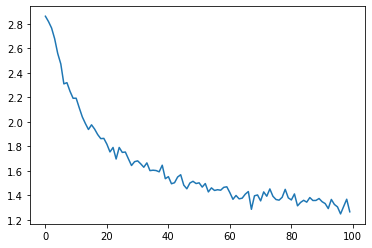

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-13-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-13-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


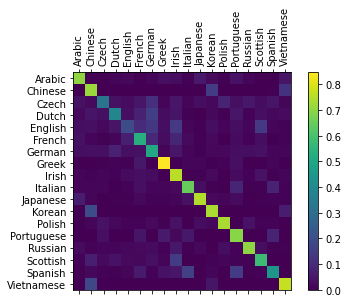

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.42) Russian
(-1.55) Czech
(-2.98) English

> Jackson
(-0.24) Scottish
(-1.99) English
(-3.29) Russian

> Satoshi
(-0.85) Japanese
(-1.56) Italian
(-2.35) Polish


# 2

In [17]:
import torch
from torchtext.datasets import AG_NEWS
train_iter = AG_NEWS(split='train')

C:\Users\wkdcl\Desktop\weekly_proj\week10\.data\AG_NEWS\train.csv: 29.5MB [00:08, 3.67MB/s]                            


In [18]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [19]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [20]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [21]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [22]:
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [23]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [24]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

C:\Users\wkdcl\Desktop\weekly_proj\week10\.data\AG_NEWS\test.csv: 1.86MB [00:00, 2.01MB/s]                             


| epoch   1 |   500/ 1782 batches | accuracy    0.694
| epoch   1 |  1000/ 1782 batches | accuracy    0.854
| epoch   1 |  1500/ 1782 batches | accuracy    0.879
-----------------------------------------------------------
| end of epoch   1 | time:  8.54s | valid accuracy    0.889 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.897
| epoch   2 |  1000/ 1782 batches | accuracy    0.899
| epoch   2 |  1500/ 1782 batches | accuracy    0.902
-----------------------------------------------------------
| end of epoch   2 | time:  8.22s | valid accuracy    0.906 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.914
| epoch   3 |  1000/ 1782 batches | accuracy    0.914
| epoch   3 |  1500/ 1782 batches | accuracy    0.915
-----------------------------------------------------------
| end of epoch   3 | time:  8.01s | valid accuracy    0.908 
-------------------------------

In [25]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.907


In [26]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


# 3

In [27]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [29]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [30]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [31]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [32]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['elle a de si beaux yeux .', 'she s got such lovely eyes .']


In [33]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [34]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [35]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [36]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [37]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [38]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [39]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [40]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [41]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [42]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 54s (- 26m 49s) (5000 6%) 2.8275
3m 46s (- 24m 30s) (10000 13%) 2.3075
5m 39s (- 22m 36s) (15000 20%) 2.0027
7m 30s (- 20m 38s) (20000 26%) 1.7261
9m 19s (- 18m 38s) (25000 33%) 1.5147
11m 11s (- 16m 46s) (30000 40%) 1.3268
13m 3s (- 14m 55s) (35000 46%) 1.2081
14m 52s (- 13m 1s) (40000 53%) 1.0672
16m 43s (- 11m 8s) (45000 60%) 0.9792
18m 42s (- 9m 21s) (50000 66%) 0.8768
20m 34s (- 7m 28s) (55000 73%) 0.8063
22m 23s (- 5m 35s) (60000 80%) 0.7520
24m 13s (- 3m 43s) (65000 86%) 0.6680
26m 12s (- 1m 52s) (70000 93%) 0.5986
28m 9s (- 0m 0s) (75000 100%) 0.5640


<Figure size 432x288 with 0 Axes>

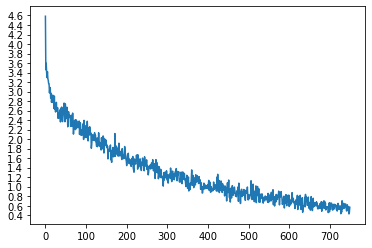

In [43]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [44]:
evaluateRandomly(encoder1, attn_decoder1)

> elle donne une fete ce soir .
= she is giving a party tonight .
< she is giving this tonight tonight . <EOS>

> je suis une inconditionnelle de l opera allemand .
= i m a fan of german opera .
< i m the fan of german opera . <EOS>

> elle est encore mineure .
= she s still under age .
< she s still on . <EOS>

> j attends un appel tres important .
= i m waiting for a very important call .
< i m waiting for waiting for the . <EOS>

> vous etes fort sceptiques .
= you re very skeptical .
< you re very skeptical . <EOS>

> il a vraiment une tenue negligee .
= he s very sloppy in his dress .
< he s very sloppy in his . <EOS>

> tu es fort curieuse .
= you re very curious .
< you re very curious . <EOS>

> je me rejouis de vous voir heureuses .
= i m glad to see you re happy .
< i m glad to see you happy happy . <EOS>

> je ne suis pas la pour me battre .
= i m not here to fight .
< i m not here to fight . <EOS>

> vous etes la meilleure .
= you re the best .
< you re the best . <EOS>



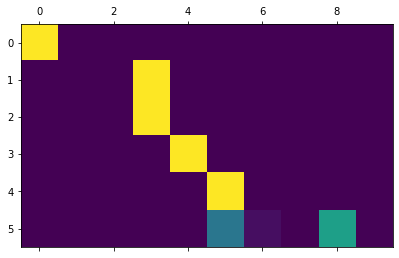

In [45]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>
input = elle est trop petit .
output = she s too too . <EOS>
input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a very young . <EOS>


<ipython-input-46-9b51ff8fc28e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-46-9b51ff8fc28e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
<ipython-input-46-9b51ff8fc28e>:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


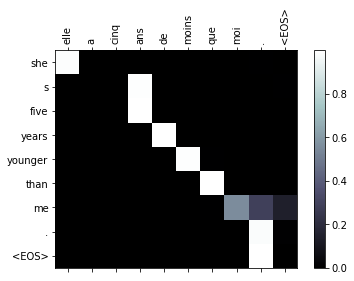

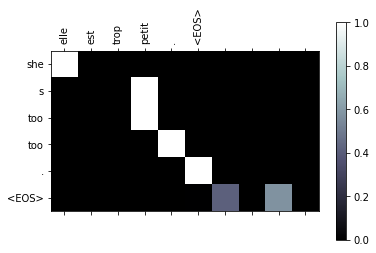

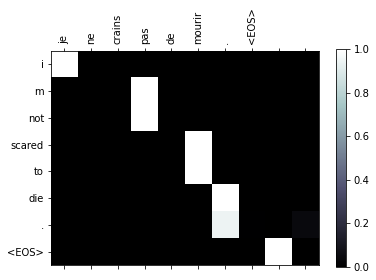

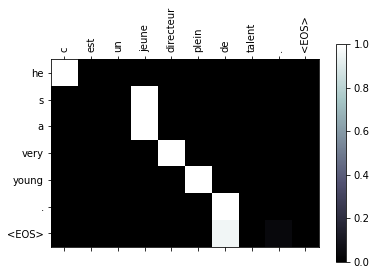

In [46]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# 4

In [47]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [48]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [49]:
import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def data_process(raw_text_iter):
  data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

C:\Users\wkdcl\Desktop\weekly_proj\week10\.data\WikiText2\wikitext-2-v1.zip: 100%|█| 4.48M/4.48M [00:03<00:00, 1.33MB/s


In [50]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [51]:
ntokens = len(vocab) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [52]:
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [53]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 91.63 | loss  8.08 | ppl  3238.11
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 91.24 | loss  6.89 | ppl   985.55
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 91.21 | loss  6.45 | ppl   629.78
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 91.31 | loss  6.30 | ppl   547.12
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 91.35 | loss  6.19 | ppl   488.20
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 91.35 | loss  6.16 | ppl   471.53
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 91.27 | loss  6.12 | ppl   455.57
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 91.27 | loss  6.11 | ppl   448.57
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 91.18 | loss  6.02 | ppl   412.36
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 91.26 | loss  6.01 | ppl   409.21
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 91.24 | loss  5.89 | ppl   361.59
| epoch   1 |  2400/ 

In [54]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.54 | test ppl   255.89
